# Note:
This needs a GPU environment, running on CPU is hopeless




# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# All the imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
from collections import OrderedDict
import json
from PIL import Image
import time
import datetime

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [2]:
use_gpu = torch.cuda.is_available()
print("GPU {}".format("Enabled" if use_gpu else "Disabled"))

!python --version
print(f"PyTorch Version {torch.__version__}")

GPU Enabled
Python 3.6.3
PyTorch Version 0.4.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
#  Define your transforms for the training, validation, and testing sets
data_transforms = {
    'training' : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}



# Load the datasets with ImageFolder
image_datasets = {
    'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation']),
    'testing' : datasets.ImageFolder(test_dir, transform=data_transforms['testing'])
}
#Using the image datasets and the trainforms, define the dataloaders
batchSize= 48
dataloaders = {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=batchSize, shuffle=True),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=batchSize, shuffle=True),
    'testing' : torch.utils.data.DataLoader(image_datasets['testing'], batch_size=batchSize)
}

print('Total train images               : ', len(image_datasets['training']))
print('Total validation images          : ', len(image_datasets['validation']))
print('Total test images                : ', len(image_datasets['testing']))
print('Number of classes in dataset     : ', len(image_datasets['training'].classes), '\n')
print('Tensor size after transformations: ', next(iter(dataloaders['training']))[0].size(), '\n')


Total train images               :  6552
Total validation images          :  818
Total test images                :  819
Number of classes in dataset     :  102 

Tensor size after transformations:  torch.Size([48, 3, 224, 224]) 



### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
#just test the names of couple of classes
df = pd.DataFrame({'flower_type': cat_to_name})
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 1 to 99
Data columns (total 1 columns):
flower_type    102 non-null object
dtypes: object(1)
memory usage: 1.6+ KB


,flower_type
1,pink primrose
10,globe thistle
100,blanket flower
101,trumpet creeper
102,blackberry lily
11,snapdragon
12,colt's foot
13,king protea
14,spear thistle
15,yellow iris


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [10]:
#Build and train your network
#see https://www.kaggle.com/pytorch/densenet121/home 
model = models.densenet201(pretrained=True)
#print(model)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier.

The classifier part is a single fully-connected layer (classifier): Linear(in_features=1920, out_features=1000). This layer was trained on the ImageNet dataset, so we need to adapt it for our problem. No need to change features part, however we need to replace the classifier.

In [11]:
#Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

fc1_in=model.classifier.in_features  #from the feature detector
fc1_out=model.classifier.out_features #from the feature detector

fc2_in=fc1_out
fc2_out=510 #we provide this

fc3_in=fc2_out
n_classes_out=len(image_datasets['training'].classes) #102 classes in our case
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(fc1_in, fc1_out)),
                          ('drop1', nn.Dropout(p=0.5)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(fc2_in, fc2_out)),
                          ('drop2', nn.Dropout(p=0.5)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(fc3_in, n_classes_out)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
#now replace the classifier part of densenet201 model with our classifier
model.classifier = classifier
#print(model)

In [12]:
criterion = nn.NLLLoss() # negative log likelihood loss as criterion.
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005) #used Adam for optimization

#Decay learning rate  by a factor of 0.1 every 5 epochs
#https://pytorch.org/docs/stable/optim.html
stepSizeLR=5
scheduler = lr_scheduler.StepLR(optimizer, step_size=stepSizeLR, gamma=0.1)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs=0

#reference
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

def train_model(model, criterion, optimizer, scheduler, epochs=n_epochs):    
 
    print(f'Starting training with {device}.....\n')
    start = time.time()
    model.to(device)
    for epoch in range(epochs):
        print('==' * 30)
        print('Epoch {}/{}...'.format(epoch+1, epochs))
       
        for phase in ['training', 'validation']:
            if phase == 'training':
                scheduler.step()
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward, track history  only in training phase
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model.forward(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward, optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            #diplay the loss and accuracy
            print('{} phase: loss= {:.4f} acc= {:.4f}'.format( phase, epoch_loss, epoch_acc))
            
   
    time_elapsed = time.time() - start
    print("\nTotal time for training: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60)) 
    return model

In [14]:
#train the model
#get the training loss, training accuracy, validation loss and validation accuracy

n_epochs=10
trainedModel = train_model(model, criterion, optimizer, scheduler, n_epochs)

Starting training with cuda:0.....

Epoch 1/10...
training phase: loss= 4.1246 acc= 0.1175
validation phase: loss= 2.9040 acc= 0.3545
Epoch 2/10...
training phase: loss= 2.5453 acc= 0.3785
validation phase: loss= 1.3340 acc= 0.6870
Epoch 3/10...
training phase: loss= 1.7119 acc= 0.5447
validation phase: loss= 0.8583 acc= 0.7812
Epoch 4/10...
training phase: loss= 1.3484 acc= 0.6358
validation phase: loss= 0.6452 acc= 0.8264
Epoch 5/10...
training phase: loss= 1.1433 acc= 0.6886
validation phase: loss= 0.5429 acc= 0.8716
Epoch 6/10...
training phase: loss= 0.9636 acc= 0.7399
validation phase: loss= 0.4189 acc= 0.9108
Epoch 7/10...
training phase: loss= 0.8995 acc= 0.7540
validation phase: loss= 0.3995 acc= 0.9034
Epoch 8/10...
training phase: loss= 0.8754 acc= 0.7645
validation phase: loss= 0.3755 acc= 0.9144
Epoch 9/10...
training phase: loss= 0.8532 acc= 0.7647
validation phase: loss= 0.3660 acc= 0.9144
Epoch 10/10...
training phase: loss= 0.8357 acc= 0.7665
validation phase: loss= 0.

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
#Do validation on the test set
def validateOnTestSet(test_loss,test_accuracy):
    #notify all layers we are doing evaluation, 
    #thus batchnorm or dropout layers will work in eval model instead of training mode.
    trainedModel.eval()
    trainedModel.to(device)
    for inputs, labels in dataloaders['testing']:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad(): #no need for grad evaluation on testing phase
            output = trainedModel.forward(inputs)
        test_loss += criterion(output, labels).item()
        # Model's output is log-softmax; need exponential to get the probabilities
        ps = torch.exp(output).data
        
        # Class with highest probability is our prediction, then compare with true label  
        equality = (labels.data == ps.max(1)[1])
        
        #Accuracy is number of correct predictions divided by all predictions
        #compare and take mean 
        #(see https://stackoverflow.com/questions/45418491/estimating-accuracy-with-x-y-mean-how-does-it-work)
        
        if(torch.cuda.is_available()):
            test_accuracy += equality.type_as(torch.cuda.FloatTensor()).mean()
        else:
            test_accuracy += equality.type_as(torch.FloatTensor()).mean()
            
    test_loss=test_loss/len(dataloaders['testing'])
    test_accuracy=test_accuracy/len(dataloaders['testing'])
    return test_loss, test_accuracy

In [16]:
print("Validating on test set ....")
start = time.time()
terr = 0.
tacc = 0.
test_error,test_accuracy=validateOnTestSet(terr,tacc)
time_elapsed = time.time() - start
print("\nTotal time for validation on test set: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))  
print("Error on test data set: {:.3f}".format(test_error))
print("Accuracy on test data set: {:.3f}".format(test_accuracy))

Validating on test set ....

Total time for validation on test set: 0m 19s
Error on test data set: 0.366
Accuracy on test data set: 0.916


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
#Save the checkpoint 
def save_checkpoint():
    model_state = {
        'epoch': n_epochs,
        'architecture':'densenet201',
        'state_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'classifier': classifier,
        'classMapping': image_datasets['training'].class_to_idx   
    }
    date=datetime.datetime.now().strftime('%m%d%Y')
    #checkpointPathName = os.path.relpath('{}_{:.3f}TestAcc_chkpt.pth'.format(date,test_accuracy))
    checkpointPathName='chkPoint_nb.pth'
    torch.save(model_state, checkpointPathName)
    print("\n==> Saved checkpoint at: ", checkpointPathName)
    
    return model_state, checkpointPathName

In [18]:
model_state,checkpointPathName=save_checkpoint()


==> Saved checkpoint at:  chkPoint_nb.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filePathName):
    print("Loading checkpoint {filePathName}")
    checkpoint = torch.load(filePathName)
    model = models.__dict__[checkpoint['architecture']](pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epoch']
    model.class_to_idx = checkpoint['classMapping']
    return model

In [20]:
checkpointPathName='chkPoint_nb.pth'
filePathName=checkpointPathName
model=load_checkpoint(filePathName)
#print("Loaded '{}' (arch={}, epochs={})".format(filePathName, model_state['architecture'], model_state['epoch']))

Loading checkpoint {filePathName}


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:
#First resize image : shortest side need to be 256 pixels and also we need to  keep the aspect ratio
def resizeImage(image, newSize):
    len_x, len_y = image.size
    aspectRatio = float(len_x)/float(len_y)
    
    if(len_x > len_y):   
        len_x=int(newSize*aspectRatio)
        len_y=int(newSize)
    elif(len_x < len_y):
        len_x=int(newSize)
        len_y=int(newSize*aspectRatio)       
    else:
        len_y=newSize
        len_x=newSize
    return image.resize((len_x, len_y))

In [22]:
#Return a cropped square region from centre of image
def cropImage(image, newSize):
    len_x, len_y = image.size
    left   = (len_x - newSize)/2
    top    = (len_y - newSize)/2
    right  = left + newSize
    bottom = top + newSize
    return image.crop((left, top, right, bottom))

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Resize image
    newSize=256
    resizedImage = resizeImage(image, newSize)
    
     #Crop image
    cropSize=224
    cropedImage = cropImage(resizedImage, cropSize)
    
    # Convert image color channels from 0-255 to floats in the range from 0 to 1
    npImage = np.array(cropedImage)/255.
    
    #adapt the sizes to network's input expectations
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npImage = (npImage - mean)/std
    
    #PyTorch expects the color channel to be the first dimension but it's the third dimension
    # in the PIL image and Numpy array. Transpose the image from x, y, color to color,x,y
    npImage = npImage.transpose((2, 0, 1))
    #print("Processed image shape is", npImage.shape)
    return npImage             

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

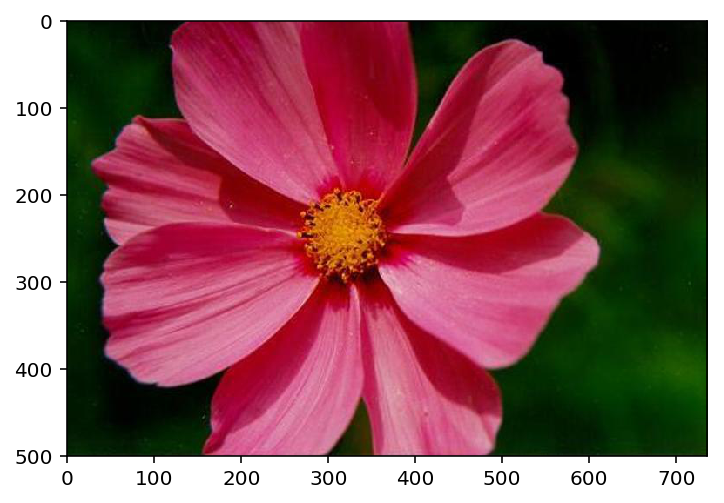

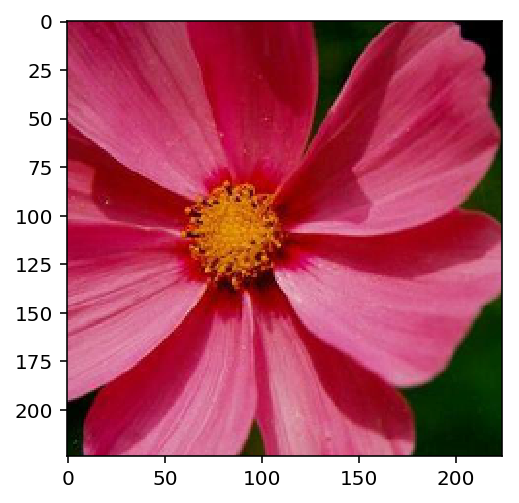

In [25]:
#check our image preprocessing code with  with an arbitrary image  (after running the above cell)
imageToTest=train_dir + '/34/image_06930.jpg'
with Image.open(imageToTest) as image:
    plt.imshow(image)
    plt.show()
    image = process_image(image)
   # imshow(torch.FloatTensor(image))
    imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [26]:
def predict(image_path, model):

    ''' Predict the class (or classes) of an image using the trained deep learning model.
    '''
    
    #load processed image
    image=Image.open(image_path)
    image_np = process_image(image)
    #print(image_np.shape)
    image_tensor = torch.FloatTensor([image_np]) #change from numpy to pytorch tensor
    #print(image_tensor.shape)
        
    model.cpu()
    model.eval()  
    LogSoftmaxPred = model.forward(image_tensor)
    probs = torch.exp(LogSoftmaxPred)
    
    # Identify top predictions and top labels
    
    topProbs, topLabels = probs.topk(5)
    #print('Probabilities: ', topProbs)
    
    #convert to numpy array
    topProbsArray = topProbs.data.numpy()[0] 
    #print('Probabilities: ', topProbsArray)
     
    # Map labels to indices 
    invertedClassToIdx = {model.class_to_idx[x]: x for x in model.class_to_idx}
    #print(invertedClassToIdx)
    
    mappedLabels = list()
    for label in topLabels.numpy()[0]:
        mappedLabels.append(invertedClassToIdx[label])
       
    return topProbsArray, mappedLabels  

In [27]:
#Use an arbitrary image and do predictions with our trained model
#display the top 5 probabilities and the top 5 labels

image_path=test_dir + '/89/image_00610.jpg'
probs, classes = predict(image_path,model)
print("Top five probs are :",probs)
print("Top five labels are :",classes)

Top five probs are : [ 0.72463363  0.2146391   0.03611946  0.01625012  0.00542566]
Top five labels are : ['53', '89', '46', '5', '65']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

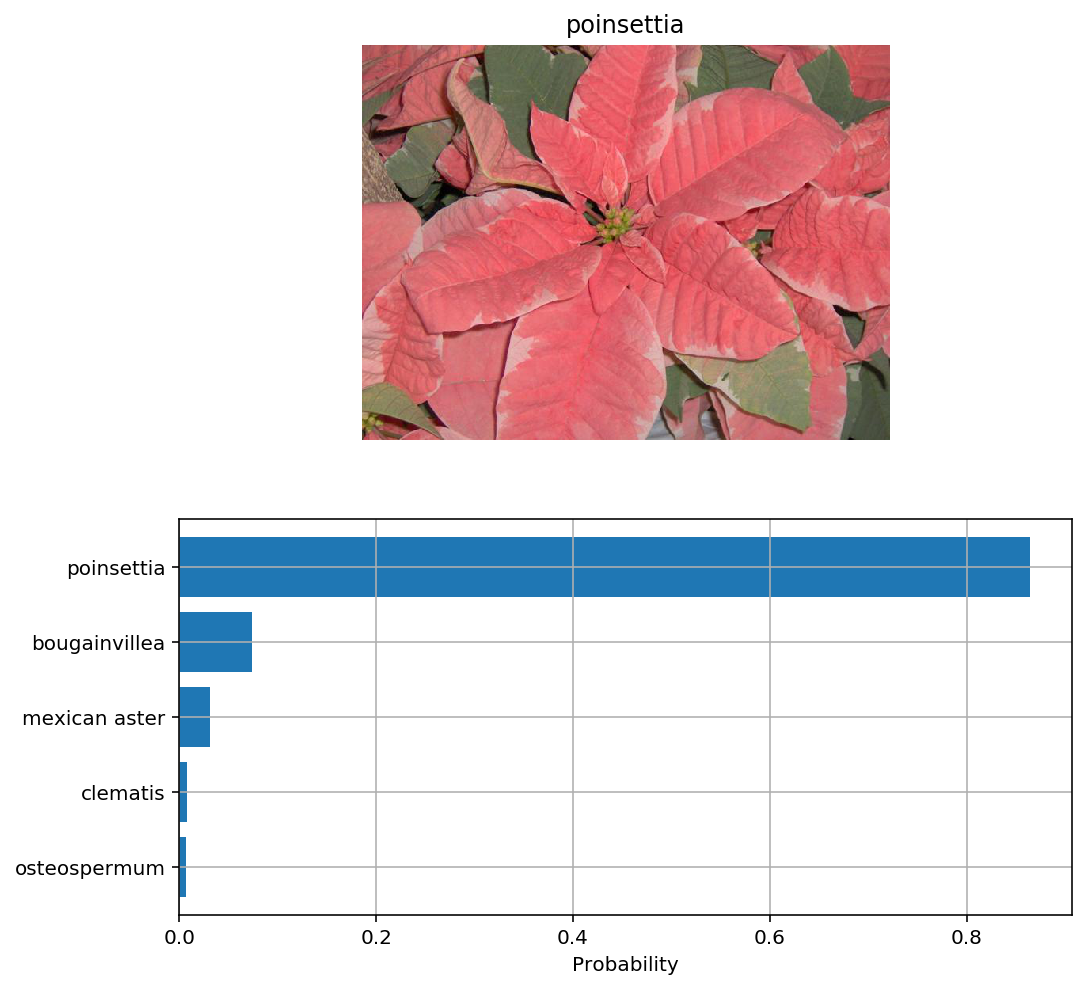

Maxprob = 0.86419 ,corresponding label is  44 and the name is poinsettia


In [28]:
#Use an arbitrary image and do predictions with our trained model
#display images and relative probabilities  with matplotlib
image_path=test_dir + '/44/image_01502.jpg'
image=Image.open(image_path)

# Get top five predictions
probs, classes = predict(image_path, model)
maxIndex = np.argmax(probs)
maxProb = probs[maxIndex]
maxLabel = classes[maxIndex]
flowerName=cat_to_name[maxLabel]

#plot the figure
fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=1, nrows=2)
ax1.set_title(flowerName)
ax1.imshow(image)
ax1.axis('off')

#plot the  top 5 predictions along withe their probabilities
y = np.arange(len(probs))
ax2.barh(y, probs)
ax2.set_yticks(y)
ax2.set_yticklabels([cat_to_name[x] for x in classes])
ax2.invert_yaxis()
ax2.set_xlabel('Probability')
plt.grid()
plt.show()

print("Maxprob =",maxProb, ",corresponding label is ",maxLabel, "and the name is",flowerName)